                                                Домашнє завдання N 5

За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах.

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features).

Почнемо з імпорту потрібних бібліотек:

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

Давайте зараз подивимось які саме підпапки з даними в нас зберігаються у датасеті data:

In [18]:
data_dir_path = os.path.join('data')
data_files = os.listdir(data_dir_path)

data_files

['running', 'idle', '.DS_Store', 'walking', 'stairs']

Як бачимо, у піддиректорії "walking" знаходяться файли з даними, названі за шаблоном "walking-<номер>".csv. Це означає, що дані з акселерометра для кожної діяльності зберігаються у форматі CSV файлів, причому кожен файл відповідає окремій сесії або запису цієї діяльності:

In [19]:
sample_activity_dir = os.path.join(data_dir_path, 'walking')
sample_files = os.listdir(sample_activity_dir)

sample_files[:5]

['walking-576.csv',
 'walking-210.csv',
 'walking-204.csv',
 'walking-1429.csv',
 'walking-562.csv']

Прочитаємо один з csv-файлів, щоб зрозуміти, які саме дані нам надані:

In [20]:
sample_file_path = os.path.join(sample_activity_dir, 'walking-1.csv')
df = pd.read_csv(sample_file_path)

# Подивимося на перші 5 рядків датасету
df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z
0,2.322376,3.643975,11.827356
1,1.781286,4.668694,6.148310
2,7.963115,-4.113238,1.359907
3,1.996764,-1.398214,1.163582
4,5.185841,-12.143391,4.687847


Перш за все, потрібно об'єднати всі файли в єдиний датасет. Це включає завантаження даних з кожного файлу, додавання мітки класу (діяльності) до кожного рядка, та об'єднання цих даних в один DataFrame:

Спочатку напишемо функцію, яка буде зчитувати дані з кожної підпапки:

In [21]:
def load_data_from_directory(directory, label):
    files = os.listdir(directory)
    data_list = []
    for file in files:
        file_path = os.path.join(directory, file)
        data = pd.read_csv(file_path)
        data['Activity'] = label
        data_list.append(data)
    return pd.concat(data_list, ignore_index=True)

Далі зчитуємо дані з кожної підпапки активності та записуємо їх в єдиний датафрейм:

In [22]:
activities = ['idle', 'running', 'stairs', 'walking']
data_frames = []
for activity in activities:
    directory_path = os.path.join('data', activity)
    df = load_data_from_directory(directory_path, activity)
    data_frames.append(df)

complete_data = pd.concat(data_frames, ignore_index=True)

complete_data.shape, complete_data.head()

((193860, 4),
    accelerometer_X  accelerometer_Y  accelerometer_Z Activity
 0         0.009577         5.937620         7.570466     idle
 1         0.086191         6.555324         7.785944     idle
 2         0.004788         6.440403         7.139510     idle
 3         0.277727         6.430826         7.690176     idle
 4        -0.047884         6.239290         7.340623     idle)

Тепер потрібно нормалізувати дані, щоб можна було потім з ними працювати. Для цьго використаємо класс StandardScaler:

In [24]:
scaler = StandardScaler()
features = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
complete_data[features] = scaler.fit_transform(complete_data[features])

complete_data

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.227723,0.347865,0.801712,idle
1,-0.218607,0.397385,0.831675,idle
2,-0.228292,0.388172,0.741787,idle
3,-0.195818,0.387404,0.818358,idle
4,-0.234559,0.372049,0.769752,idle
...,...,...,...,...
193855,-0.452192,-0.883975,-0.598540,walking
193856,-1.429830,-1.235984,-0.416767,walking
193857,-0.338248,-0.290895,2.896430,walking
193858,-0.204934,-1.132723,-0.197707,walking


Далі нам потрібно розрахувати часові ознаки (time domain features). 

Для цього ми розділимо наш датасет на сегменти по 208 записів з перекриттям у 50% та розрахуємо часові ознаки для кожного сегмента.

Розрахуємо такі показники:

Середнє значення (mean), 
Стандартне відхилення (std), 
Медіана (median), 
Максимальне значення (max), 
Мінімальне значення (min), 
Діапазон (range), 
Квартилі (25% та 75%)

In [28]:
segment_length = 208
step = 104
segments = []
labels = []

for start_pos in range(0, len(complete_data) - segment_length + 1, step):
    segment = complete_data.iloc[start_pos:start_pos + segment_length]

    features = {
        'mean_X': segment['accelerometer_X'].mean(),
        'std_X': segment['accelerometer_X'].std(),
        'median_X': segment['accelerometer_X'].median(),
        'max_X': segment['accelerometer_X'].max(),
        'min_X': segment['accelerometer_X'].min(),
        'range_X': segment['accelerometer_X'].max() - segment['accelerometer_X'].min(),
        '25%_X': segment['accelerometer_X'].quantile(0.25),
        '75%_X': segment['accelerometer_X'].quantile(0.75),
        'mean_Y': segment['accelerometer_Y'].mean(),
        'std_Y': segment['accelerometer_Y'].std(),
        'median_Y': segment['accelerometer_Y'].median(),
        'max_Y': segment['accelerometer_Y'].max(),
        'min_Y': segment['accelerometer_Y'].min(),
        'range_Y': segment['accelerometer_Y'].max() - segment['accelerometer_Y'].min(),
        '25%_Y': segment['accelerometer_Y'].quantile(0.25),
        '75%_Y': segment['accelerometer_Y'].quantile(0.75),
        'mean_Z': segment['accelerometer_Z'].mean(),
        'std_Z': segment['accelerometer_Z'].std(),
        'median_Z': segment['accelerometer_Z'].median(),
        'max_Z': segment['accelerometer_Z'].max(),
        'min_Z': segment['accelerometer_Z'].min(),
        'range_Z': segment['accelerometer_Z'].max() - segment['accelerometer_Z'].min(),
        '25%_Z': segment['accelerometer_Z'].quantile(0.25),
        '75%_Z': segment['accelerometer_Z'].quantile(0.75)
    }

    segments.append(features)
    labels.append(segment['Activity'].iloc[0])

features_df = pd.DataFrame(segments)
features_df['Activity'] = labels

features_df

,mean_X,std_X,median_X,max_X,min_X,range_X,25%_X,75%_X,mean_Y,std_Y,...,75%_Y,mean_Z,std_Z,median_Z,max_Z,min_Z,range_Z,25%_Z,75%_Z,Activity
0,-0.212513,0.032946,-0.200946,-0.108651,-0.334260,0.225609,-0.230714,-0.196388,0.085123,0.256828,...,0.376176,0.962012,0.174827,1.104001,1.113989,0.589311,0.524678,0.785066,1.107331,idle
1,-0.213625,0.036182,-0.201516,-0.108651,-0.398638,0.289987,-0.227295,-0.197527,0.017541,0.209479,...,0.245756,1.024040,0.126321,1.104667,1.113989,0.589311,0.524678,0.940872,1.107331,idle
2,-0.216224,0.096938,-0.205503,0.679840,-0.684068,1.363908,-0.250511,-0.197955,0.164523,0.203131,...,0.316484,0.941659,0.159143,0.931550,1.159266,-0.292256,1.451521,0.853314,1.103003,idle
3,-0.218106,0.105243,-0.204079,0.679840,-0.684068,1.363908,-0.266321,-0.194536,0.210584,0.202597,...,0.344891,0.901146,0.167426,0.893597,1.211201,-0.292256,1.503456,0.792723,1.049070,idle
4,-0.217659,0.059832,-0.199806,0.049731,-0.449913,0.499644,-0.235841,-0.196815,0.062364,0.246669,...,0.328192,0.979429,0.173129,1.104667,1.211201,0.552690,0.658511,0.832507,1.107996,idle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,-0.506036,0.567687,-0.490363,1.541256,-2.604022,4.145278,-0.749443,-0.216186,-0.967910,0.497356,...,-0.682059,-0.398434,0.881130,-0.344524,3.324563,-3.752602,7.077165,-0.691757,0.022019,walking
1859,-0.607060,0.559584,-0.531953,1.541256,-2.441652,3.982908,-0.840598,-0.327993,-0.942709,0.469070,...,-0.690120,-0.384573,1.014656,-0.314894,4.513079,-3.752602,8.265681,-0.684599,0.018024,walking
1860,-0.681803,0.533568,-0.544487,0.217228,-3.282558,3.499786,-0.901701,-0.358473,-0.862585,0.430156,...,-0.611523,-0.383968,0.928449,-0.324881,4.513079,-3.843822,8.356900,-0.617017,-0.055052,walking
1861,-0.744735,0.575763,-0.594052,0.201276,-3.282558,3.483834,-0.971349,-0.431540,-0.906750,0.415963,...,-0.666128,-0.430929,0.957865,-0.372822,4.913246,-3.843822,8.757068,-0.622510,-0.085347,walking


Тепер нам потрібно розділити наш набір даних на тренувальну та тестову вибірку:

In [40]:
X = features_df.drop('Activity', axis=1)
y = features_df['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Тепер застосуємо метод Support Vector Machine для тренування нашої моделі:

In [41]:
svc_clf = SVC(kernel='linear', C=1.0, random_state=42)
svc_clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Проведемо прогнозування та оцінку моделі:

In [47]:
y_predict_svc = svc_clf.predict(X_test)

print(f"accuracy score on training sample = {accuracy_score(svc_clf.predict(X_train), y_train)}")
print(f"accuracy score on test sample = {accuracy_score(svc_clf.predict(X_test), y_test)}\n")

print(classification_report(y_test, y_predict_svc))

accuracy score on training sample = 0.9983974358974359
accuracy score on test sample = 0.9983739837398374

              precision    recall  f1-score   support

        idle       1.00      1.00      1.00        86
     running       1.00      1.00      1.00       328
      stairs       1.00      0.95      0.97        19
     walking       0.99      1.00      1.00       182

    accuracy                           1.00       615
   macro avg       1.00      0.99      0.99       615
weighted avg       1.00      1.00      1.00       615



Також зробимо візуальну оцінку за допомогою Confusion Matrix:

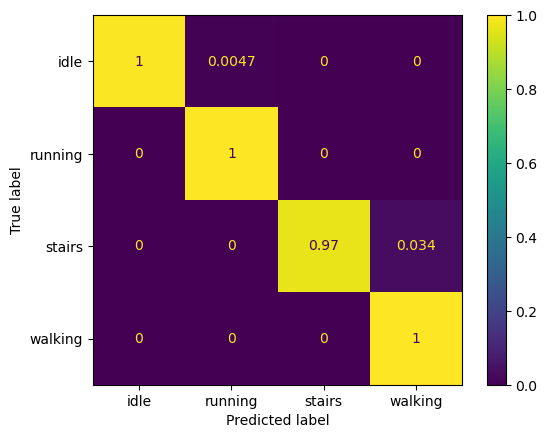

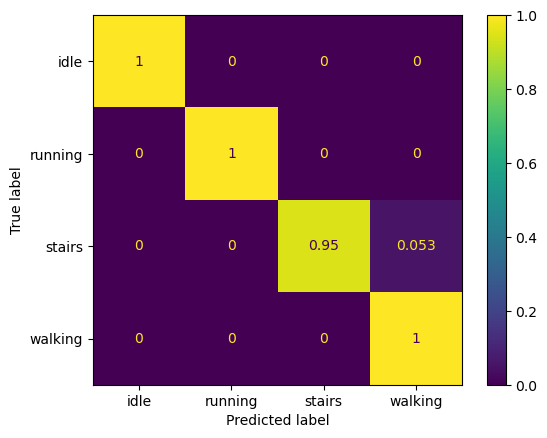

In [49]:
matrix_train=ConfusionMatrixDisplay.from_estimator(svc_clf, X_train, y_train, normalize='true')
matrix_test=ConfusionMatrixDisplay.from_estimator(svc_clf, X_test, y_test, normalize='true')